Extracting embeddings and morphological features...


/usr/local/lib/python3.11/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Before SMOTE - Data: [15505  2577]
After SMOTE - Data: [15505 15505]

📊 Test Evaluation Summary:
✅ Test Accuracy   : 0.7722
✅ Test ROC-AUC    : 0.8580
✅ Classification Report:
               precision    recall  f1-score   support

  Non-Damage       0.80      0.73      0.76      3101
      Damage       0.75      0.82      0.78      3101

    accuracy                           0.77      6202
   macro avg       0.77      0.77      0.77      6202
weighted avg       0.77      0.77      0.77      6202



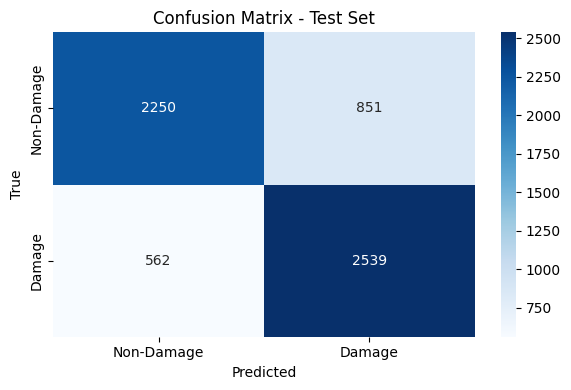

In [3]:
import pandas as pd
import numpy as np
import spacy
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# ====================== Load spaCy model ======================
nlp = spacy.load("en_core_web_sm")

# ====================== Load Data ======================
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"  # Update folder & filename if different
df = pd.read_csv(file_path)

# ====================== Preprocess Labels ======================
label_map = {'damage': 1, 'non-damage': 0}
df['Binary_class'] = df['Binary_class'].str.strip().str.lower().map(label_map)
df['Processed_data'] = df['Processed_data'].fillna("")

# ====================== ELAMO Feature Extraction ======================
def get_spacy_embeddings(texts, fallback_dim=96):
    vectors = []
    for doc in nlp.pipe(texts, disable=["parser", "ner", "tagger"]):
        vec = doc.vector
        if vec is not None and vec.shape[0] > 0:
            vectors.append(vec)
        else:
            vectors.append(np.zeros(fallback_dim))
    return np.vstack(vectors)

def extract_morphological_features(texts):
    pos_tags = []
    lemmas = []
    for doc in nlp.pipe(texts, disable=["parser", "ner"]):
        pos_tags.append([token.pos_ for token in doc])
        lemmas.append([token.lemma_ for token in doc])
    return pos_tags, lemmas

def combine_elamo_features(X_embed, pos_tags, lemmas):
    pos_diversity = np.array([[len(set(tags))] for tags in pos_tags])
    lemma_diversity = np.array([[len(set(l))] for l in lemmas])
    return np.hstack((X_embed, pos_diversity, lemma_diversity))

# ====================== Apply ELAMO to the complete data ======================
print("Extracting embeddings and morphological features...")

# Extract features from the entire dataset
X_embed = get_spacy_embeddings(df['Processed_data'])
pos_tags, lemmas = extract_morphological_features(df['Processed_data'])

# Combine all features into a final feature set
X = combine_elamo_features(X_embed, pos_tags, lemmas)

y = df['Binary_class'].values

# ====================== Apply SMOTE to the entire data ======================
print("Before SMOTE - Data:", np.bincount(y))
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
print("After SMOTE - Data:", np.bincount(y_smote))

# ====================== Stratified Split (80% Train, 20% Test) ======================
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.20, stratify=y_smote, random_state=42)

# ====================== Random Forest Model ======================
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# ====================== Train the Model ======================
rf_model.fit(X_train, y_train)

# ====================== Evaluate on Test Set ======================
test_preds = rf_model.predict(X_test)
test_proba = rf_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, test_proba)

print("\n📊 Test Evaluation Summary:")
print(f"✅ Test Accuracy   : {accuracy_score(y_test, test_preds):.4f}")
print(f"✅ Test ROC-AUC    : {roc_auc:.4f}")
print("✅ Classification Report:\n", classification_report(y_test, test_preds, target_names=['Non-Damage', 'Damage']))

# ====================== Confusion Matrix ======================
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Damage', 'Damage'],
            yticklabels=['Non-Damage', 'Damage'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()
